In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import scipy.io
from sklearn.preprocessing import LabelEncoder

np.random.seed(42)

In [5]:
# Imports
#!pip install tensorflow==2.16.0rc0
#!PYTHONHASHSEED=0
import tensorflow as tf
from tensorflow import keras
from google.colab import drive
from shutil import copyfile
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import zipfile
import random as python_random
import os
import zipfile
from scipy.io import loadmat
from sklearn.preprocessing import LabelEncoder
import io
#np.random.seed(0)
#python_random.seed(0)
#tf.random.set_seed(0)

In [6]:
# Link Google Drive account and download t-dataset
drive.mount('/content/gdrive')
copyfile('gdrive/My Drive/Colab Notebooks/training2017.zip', 'training2017.zip')
zipp = zipfile.ZipFile('training2017.zip')
zipp.extractall()
zipp.close()

Mounted at /content/gdrive


In [7]:
# Link Google Drive account and download csv label dataset
copyfile('gdrive/My Drive/Colab Notebooks/REFERENCE.csv', 'REFERENCE.csv')

'REFERENCE.csv'

In [8]:
# Storing the output
le = LabelEncoder()
data = pd.read_csv('REFERENCE.csv', header=None, names=['name', 'label'])
y = le.fit_transform(data.label.values)
y = y.reshape(-1, 1)

In [9]:
# Get the number of unique labels
num_labels = len(le.classes_)

# Print the labels encoding
print('Labels encoding:')
for i in range(num_labels):
    print(i, le.inverse_transform([i])[0])

Labels encoding:
0 A
1 N
2 O
3 ~


In [10]:
# Storing the input
def get_data(file):
    data = scipy.io.loadmat(file)['val'][0]
    return data.astype(float)

data_list = [get_data('training2017/{}.mat'.format(i)) for i in data.name.values]

X = np.array(data_list, dtype=object)

In [11]:
sampling_frequency = 300
dt = 1/sampling_frequency
print('The timestep is: ', dt)

The timestep is:  0.0033333333333333335


The ECG were sampled as 300 Hz.
This means every datapoint represent an increment in time of $\frac{1}{300Hz}=0.0033333333333333335s$

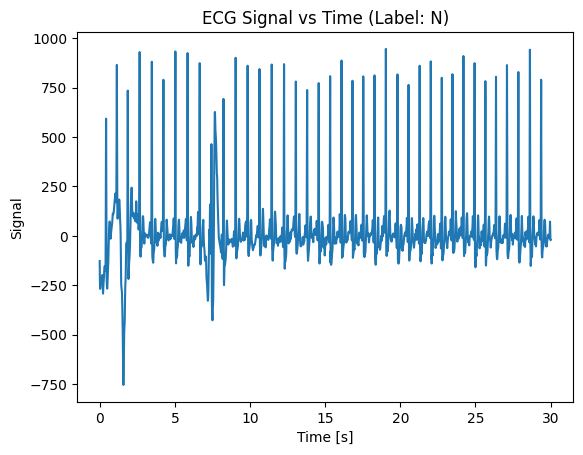

In [12]:
idx = 0

plt.plot(dt*np.arange(len(X[idx])),X[idx])
plt.xlabel('Time [s]')
plt.ylabel('Signal')
plt.title(f'ECG Signal vs Time (Label: {le.inverse_transform(y[idx])[0]})')
plt.show()

# Data Exploration

Labels distribution:
Class: 0 , Count: 738 , Perc :8.7%
Class: 1 , Count: 5050 , Perc :59.2%
Class: 2 , Count: 2456 , Perc :28.8%
Class: 3 , Count: 284 , Perc :3.3%


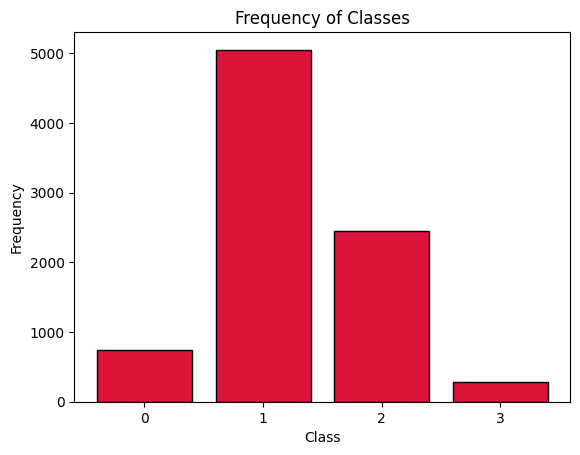

In [13]:
unique_classes, class_counts = np.unique(y, return_counts=True)

print('Labels distribution:')
for i in range(num_labels):
    print('Class:', i, ', Count:', class_counts[i], ', Perc :{:.1f}%'.format(100*class_counts[i]/len(y)))

plt.bar(unique_classes, class_counts, edgecolor='black', color='crimson')
plt.title('Frequency of Classes')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.xticks(unique_classes)
plt.show()

In [14]:
print("Shape of X:", X.shape)

Shape of X: (8528,)


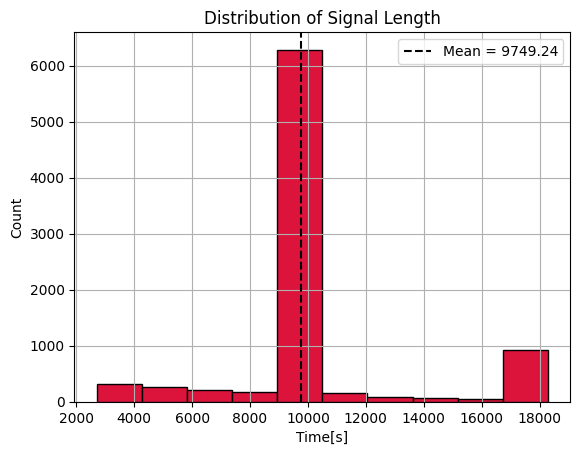

In [15]:
signal_lengths = [len(X[i]) for i in range(0, len(X))]

plt.hist(signal_lengths, edgecolor='black', color='crimson')
plt.axvline(np.mean(signal_lengths), linestyle='--', c='black', label=f'Mean = {np.mean(signal_lengths):.2f}')
plt.title('Distribution of Signal Length')
plt.xlabel('Time[s]')
plt.ylabel('Count')
plt.legend()
plt.grid(True)
plt.show()

# Preprocessing

In [16]:
def segment_signals(signals, labels, segment_length=9000):

    segmented_signals = []
    segmented_labels = []

    for signal, label in zip(signals, labels):
        signal_length = len(signal)
        if signal_length >= segment_length:
            num_segments = signal_length // segment_length
            for i in range(num_segments):
                start_idx = i * segment_length
                end_idx = start_idx + segment_length
                segment = signal[start_idx:end_idx]
                segmented_signals.append(segment)
                segmented_labels.append(label)

    return np.array(segmented_signals), np.array(segmented_labels)


segmented_X, segmented_y = segment_signals(X, y)
names_encoding = le.inverse_transform(segmented_y.ravel())
print(segmented_X.shape)
print(segmented_y.shape)

(8409, 9000)
(8409, 1)


In [17]:
label_mapping = {label: le.transform([label])[0] for label in le.classes_}

X_A = segmented_X[segmented_y.ravel() == label_mapping['A']]
y_A = segmented_y[segmented_y.ravel() == label_mapping['A']]

X_N = segmented_X[segmented_y.ravel() == label_mapping['N']]
y_N = segmented_y[segmented_y.ravel() == label_mapping['N']]

X_O = segmented_X[segmented_y.ravel() == label_mapping['O']]
y_O = segmented_y[segmented_y.ravel() == label_mapping['O']]

X_Noise = segmented_X[segmented_y.ravel() == label_mapping['~']]
y_Noise = segmented_y[segmented_y.ravel() == label_mapping['~']]

print(X_A.shape, y_A.shape)
print(X_N.shape, y_N.shape)
print(X_O.shape, y_O.shape)
print(X_Noise.shape, y_Noise.shape)

(718, 9000) (718, 1)
(4937, 9000) (4937, 1)
(2603, 9000) (2603, 1)
(151, 9000) (151, 1)


In [18]:
# Repeat arrays and concatenate the first two arrays for the moment

XTrain = np.concatenate((np.repeat(X_A, 7, axis=0), X_N))
yTrain = np.concatenate((np.repeat(y_A, 7, axis=0), y_N))

# Check balance of features

unique, counts = np.unique(yTrain, return_counts=True)
print('Training', unique, ' ', counts)

Training [0 1]   [5026 4937]


In [19]:
from sklearn.model_selection import train_test_split

X_train, X_temp, y_train, y_temp = train_test_split(XTrain, yTrain, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [20]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

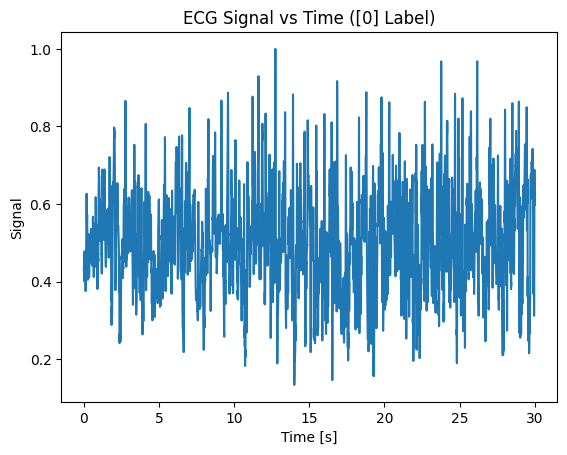

In [21]:
idx = 0

plt.plot(dt*np.arange(len(X_train_scaled[idx])),X_train_scaled[idx])
plt.xlabel('Time [s]')
plt.ylabel('Signal')
plt.title(f'ECG Signal vs Time ({y_train[idx]} Label)')
plt.show()

## Computing spectrogram

In [22]:
from scipy import signal

frequencies, times, Sxx_train = signal.spectrogram(X_train_scaled, sampling_frequency)
frequencies, times, Sxx_val = signal.spectrogram(X_val_scaled, sampling_frequency)
frequencies, times, Sxx_test = signal.spectrogram(X_test_scaled, sampling_frequency)

print(times.shape)
print(frequencies.shape)
print(Sxx_train.shape)
print(Sxx_train[0].shape)

(40,)
(129,)
(7970, 129, 40)
(129, 40)


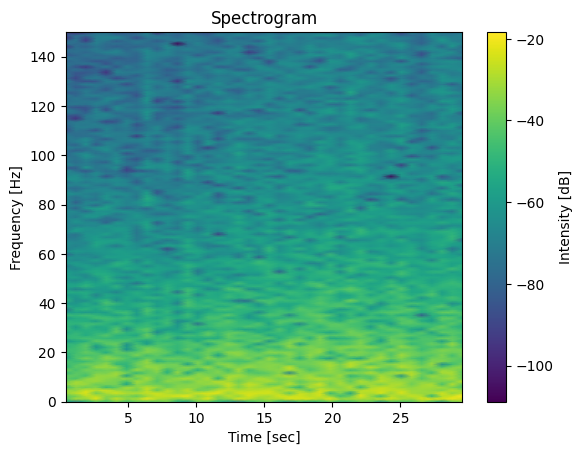

In [23]:
idx=0

plt.pcolormesh(times, frequencies, 10*np.log10(Sxx_train[idx]), shading='gouraud')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.title('Spectrogram')
plt.colorbar(label='Intensity [dB]')
plt.show()

In [25]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()


# Reshape the spectrograms
Sxx_train_reshaped = Sxx_train.reshape(Sxx_train.shape[0], -1)
Sxx_val_reshaped = Sxx_val.reshape(Sxx_val.shape[0], -1)
Sxx_test_reshaped = Sxx_test.reshape(Sxx_test.shape[0], -1)

# Fit and transform on train set
Sxx_train_scaled = scaler.fit_transform(Sxx_train_reshaped)

# Transform on validation and test sets
Sxx_val_scaled = scaler.transform(Sxx_val_reshaped)
Sxx_test_scaled = scaler.transform(Sxx_test_reshaped)

# Reshape back to original shape
Sxx_train_scaled = Sxx_train_scaled.reshape(Sxx_train.shape)
Sxx_val_scaled = Sxx_val_scaled.reshape(Sxx_val.shape)
Sxx_test_scaled = Sxx_test_scaled.reshape(Sxx_test.shape)

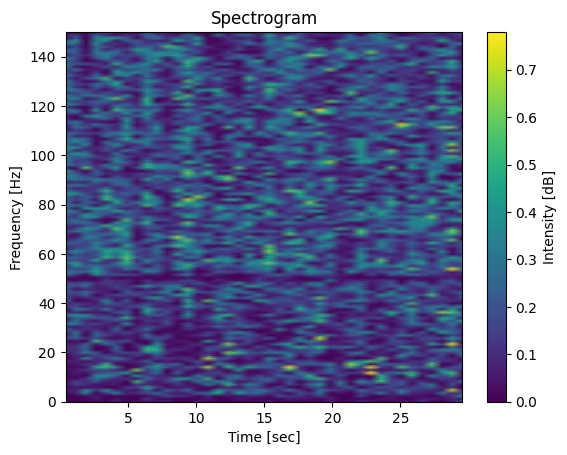

In [26]:
idx=0

plt.pcolormesh(times, frequencies, Sxx_train_scaled[idx], shading='gouraud')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.title('Spectrogram')
plt.colorbar(label='Intensity [dB]')
plt.show()

# Neural Network

In [26]:

# Define the architecture of the NN
input_shape = (9000, 1)  # Each input is a sequence of 9000 timesteps with 1 feature per timestep

inputs = keras.layers.Input(shape=input_shape)
x = inputs

# Add convolutional layers to extract spatial features
x = keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu')(x)
x = keras.layers.MaxPooling1D(pool_size=2)(x)
x = keras.layers.Conv1D(filters=128, kernel_size=3, activation='relu')(x)
x = keras.layers.MaxPooling1D(pool_size=2)(x)

# Add bidirectional LSTM layers with dropout
x = keras.layers.Bidirectional(keras.layers.LSTM(128, return_sequences=True))(x)
x = keras.layers.Dropout(0.5)(x)
x = keras.layers.Bidirectional(keras.layers.LSTM(128))(x)
x = keras.layers.Dropout(0.5)(x)

# Add fully connected layers
x = keras.layers.Dense(64, activation='relu', kernel_regularizer=keras.regularizers.l2(0.01))(x)
x = keras.layers.Dropout(0.5)(x)
x = keras.layers.Dense(32, activation='relu', kernel_regularizer=keras.regularizers.l2(0.01))(x)
x = keras.layers.Dropout(0.5)(x)

# Add final output layer
outputs = keras.layers.Dense(2, activation='softmax')(x)

In [27]:
# Create the model
net = keras.Model(inputs=inputs, outputs=outputs)


# Compile the model

learning_rate = 0.001
epochs = 5

net.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [28]:
net.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 9000, 1)]         0         
                                                                 
 conv1d (Conv1D)             (None, 8998, 64)          256       
                                                                 
 max_pooling1d (MaxPooling1  (None, 4499, 64)          0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 4497, 128)         24704     
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 2248, 128)         0         
 g1D)                                                            
                                                                 
 bidirectional (Bidirection  (None, 2248, 256)         263168

In [29]:
# Callbacks for early stopping and learning rate reduction
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
#lr_reduction = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

In [30]:
history = net.fit(
    x=X_train_scaled,
    y=y_train,
    epochs=epochs,
    validation_data=(X_val_scaled, y_val),
    callbacks=[early_stopping],
    batch_size=128
)

Epoch 1/5
63/63 [==============================] - 64s 809ms/step - loss: 1.5484 - accuracy: 0.5054 - val_loss: 1.1089 - val_accuracy: 0.5070
Epoch 2/5
63/63 [==============================] - 47s 747ms/step - loss: 0.9316 - accuracy: 0.4956 - val_loss: 0.8093 - val_accuracy: 0.5070
Epoch 3/5
63/63 [==============================] - 47s 748ms/step - loss: 0.7616 - accuracy: 0.5040 - val_loss: 0.7284 - val_accuracy: 0.5070
Epoch 4/5
63/63 [==============================] - 47s 748ms/step - loss: 0.7147 - accuracy: 0.5035 - val_loss: 0.7045 - val_accuracy: 0.5070
Epoch 5/5
63/63 [==============================] - 47s 743ms/step - loss: 0.7001 - accuracy: 0.4996 - val_loss: 0.6967 - val_accuracy: 0.5070


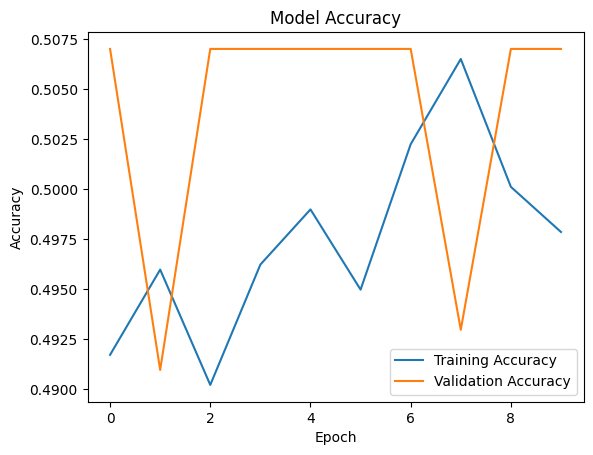

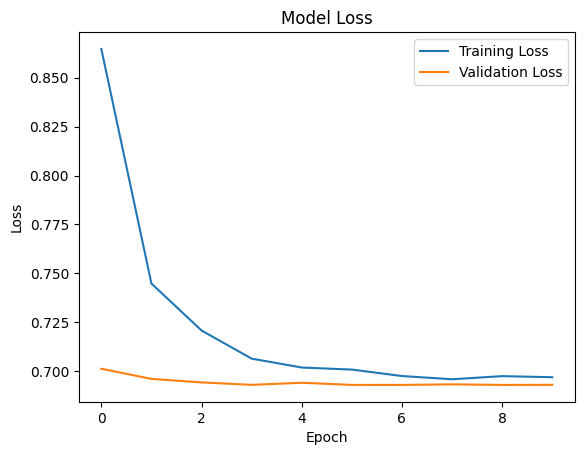

In [56]:
# Plot training & validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Plot training & validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Trying a CNN on the spectrogram

In [27]:
print(Sxx_train_scaled.shape)

(7970, 129, 40)


In [28]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.optimizers import Adam

# Define the input shape
input_shape = (129, 40, 1)  # Height, Width, Channels (assuming grayscale)

# Define the model
model = Sequential()

# Convolutional layers
model.add(Conv2D(32, kernel_size=(3, 3), activation='tanh', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, kernel_size=(3, 3), activation='tanh'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, kernel_size=(3, 3), activation='tanh'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten layer to feed into fully connected layers
model.add(Flatten())

# Fully connected layers
model.add(Dense(128, activation='tanh'))
model.add(Dropout(0.5))  # Dropout for regularization

model.add(Dense(64, activation='tanh'))
model.add(Dropout(0.5))  # Dropout for regularization

# Output layer
model.add(Dense(4, activation='softmax'))

# Compile the model
optimizer = Adam(learning_rate=0.1)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Print model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 127, 38, 32)       320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 63, 19, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 17, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 30, 8, 64)         0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 6, 128)        73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 14, 3, 128)        0

In [29]:
from keras.utils import to_categorical

# Assuming y_train and y_val are your target labels
num_classes = 4  # Replace with the number of classes in your dataset
y_train_encoded = to_categorical(y_train, num_classes)
y_val_encoded = to_categorical(y_val, num_classes)

In [30]:
batch_size = 128
epochs = 100

from keras.callbacks import EarlyStopping
# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Compile the model with appropriate parameters
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Fit the model
history = model.fit(
    x=Sxx_train_scaled,
    y=y_train_encoded,
    epochs=epochs,
    validation_data=(Sxx_val_scaled, y_val_encoded),
    callbacks=[early_stopping],
    batch_size=batch_size
)

Epoch 1/100
63/63 [==============================] - 10s 37ms/step - loss: 0.8131 - accuracy: 0.4861 - val_loss: 0.7009 - val_accuracy: 0.5151
Epoch 2/100
63/63 [==============================] - 1s 21ms/step - loss: 0.7316 - accuracy: 0.5118 - val_loss: 0.6930 - val_accuracy: 0.5030
Epoch 3/100
63/63 [==============================] - 1s 21ms/step - loss: 0.7090 - accuracy: 0.5304 - val_loss: 0.6814 - val_accuracy: 0.5622
Epoch 4/100
63/63 [==============================] - 1s 21ms/step - loss: 0.6766 - accuracy: 0.5944 - val_loss: 0.6362 - val_accuracy: 0.6948
Epoch 5/100
63/63 [==============================] - 1s 24ms/step - loss: 0.5491 - accuracy: 0.7350 - val_loss: 0.4501 - val_accuracy: 0.8082
Epoch 6/100
63/63 [==============================] - 1s 23ms/step - loss: 0.3256 - accuracy: 0.8731 - val_loss: 0.3533 - val_accuracy: 0.8343
Epoch 7/100
63/63 [==============================] - 2s 25ms/step - loss: 0.1929 - accuracy: 0.9272 - val_loss: 0.1490 - val_accuracy: 0.9558
Epoch

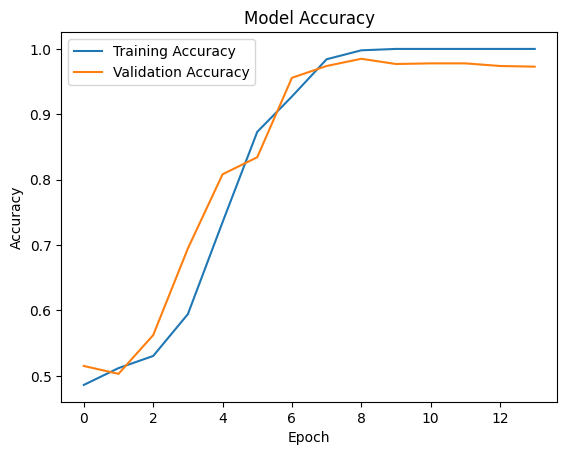

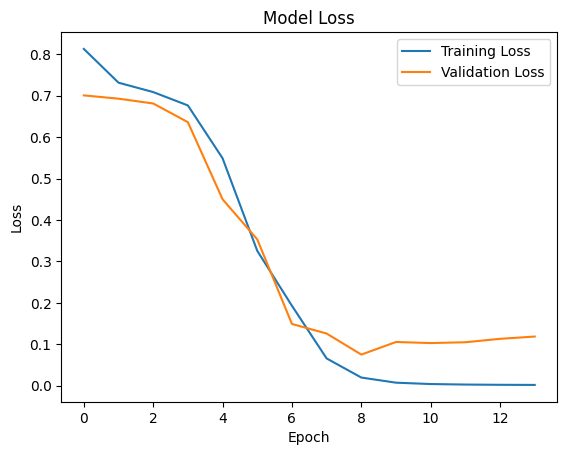

In [31]:
# Plot training & validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Plot training & validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

32/32 [==============================] - 1s 9ms/step
Confusion Matrix:
[[508   0]
 [ 18 471]]


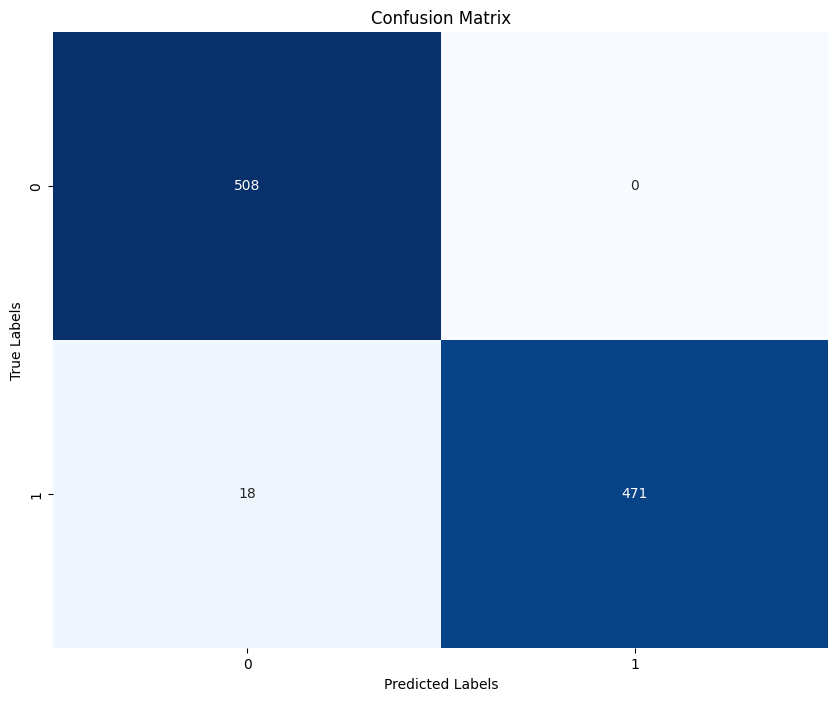

In [32]:
from sklearn.metrics import confusion_matrix

y_pred = model.predict(Sxx_test_scaled)

# Convert probabilities to class labels
y_pred_classes = np.argmax(y_pred, axis=1)

# Now you can compute the confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)

# Print confusion matrix
print("Confusion Matrix:")
print(cm)

# If you want to visualize the confusion matrix, you can use libraries like matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# Create a heatmap of the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()